# 🌍 Climate Dataset Analysis

This notebook analyzes the climate tweets dataset for LLM agent training.

## Overview
- **Dataset**: `climate_tweets2.jsonl`
- **Focus**: Climate-related Twitter discussions and user behavior
- **Goal**: Extract patterns for climate-focused LLM agents

## Memory Management
- Designed for 16GB RAM systems
- Memory monitoring throughout analysis
- Efficient data processing and cleanup

In [4]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from datetime import datetime
import gc
import psutil
import os
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def print_memory_status():
    """Print current memory status"""
    memory_mb = get_memory_usage()
    print(f"💾 Current memory usage: {memory_mb:.1f} MB")
    if memory_mb > 12000:  # Warning at 12GB
        print("⚠️  High memory usage detected!")

print("🌍 CLIMATE DATASET ANALYSIS NOTEBOOK")
print("=" * 50)
print_memory_status()

🌍 CLIMATE DATASET ANALYSIS NOTEBOOK
💾 Current memory usage: 489.5 MB


In [5]:
class ClimateTwitterAnalyzer:
    def __init__(self, jsonl_file_path='climate_tweets2.jsonl', max_tweets=None):
        """Initialize the climate analyzer"""
        self.jsonl_file = jsonl_file_path
        self.max_tweets = max_tweets
        self.tweets_df = None
        self.users_df = None
        print(f"🌍 Initializing Climate Twitter Analyzer")
        self.load_data()
    
    def load_data(self):
        """Load and parse climate JSONL data with memory management"""
        print(f"Loading climate data from {self.jsonl_file}...")
        print_memory_status()
        
        tweets_data = []
        
        with open(self.jsonl_file, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                try:
                    tweet = json.loads(line.strip())
                    tweets_data.append(tweet)
                    
                    # Memory check and optional limit
                    if self.max_tweets and len(tweets_data) >= self.max_tweets:
                        print(f"📊 Reached tweet limit of {self.max_tweets}")
                        break
                        
                    if line_num % 10000 == 0:
                        memory_mb = get_memory_usage()
                        print(f"   Processed {line_num:,} lines, Memory: {memory_mb:.1f} MB")
                        if memory_mb > 14000:  # Stop at 14GB to be safe
                            print("⚠️  Memory limit approaching, stopping data load")
                            break
                            
                except json.JSONDecodeError as e:
                    if line_num % 1000 == 0:  # Only print occasional errors
                        print(f"Error parsing line {line_num}: {e}")
                    continue
        
        print(f"Loaded {len(tweets_data)} climate tweets")
        print_memory_status()
        
        # Create DataFrames
        print("Creating tweets DataFrame...")
        self.tweets_df = pd.json_normalize(tweets_data)
        
        # Extract user data efficiently
        print("Extracting user data...")
        users_data = []
        for tweet in tweets_data:
            if 'user' in tweet:
                user_data = {
                    'id_str': tweet['user'].get('id_str'),
                    'screen_name': tweet['user'].get('screen_name'),
                    'followers_count': tweet['user'].get('followers_count', 0),
                    'friends_count': tweet['user'].get('friends_count', 0),
                    'verified': tweet['user'].get('verified', False),
                    'created_at': tweet['user'].get('created_at'),
                    'statuses_count': tweet['user'].get('statuses_count', 0)
                }
                users_data.append(user_data)
        
        self.users_df = pd.DataFrame(users_data)
        
        # Clean up raw data
        del tweets_data
        del users_data
        gc.collect()
        
        # Convert timestamps
        if 'created_at' in self.tweets_df.columns:
            self.tweets_df['created_at'] = pd.to_datetime(self.tweets_df['created_at'], errors='coerce')
        if 'created_at' in self.users_df.columns:
            self.users_df['created_at'] = pd.to_datetime(self.users_df['created_at'], errors='coerce')
        
        print("✅ Climate data loading complete")
        print_memory_status()
    
    def basic_statistics(self):
        """Generate basic statistics about the climate dataset"""
        print("=" * 60)
        print("🌍 CLIMATE DATASET STATISTICS")
        print("=" * 60)
        
        # Dataset overview
        print(f"📊 Total climate tweets: {len(self.tweets_df):,}")
        print(f"👥 Unique users: {self.tweets_df['user.id_str'].nunique():,}")
        print(f"📅 Date range: {self.tweets_df['created_at'].min()} to {self.tweets_df['created_at'].max()}")
        
        # Content statistics
        print(f"\n📝 CONTENT STATISTICS:")
        print(f"   • Average tweet length: {self.tweets_df['full_text'].str.len().mean():.1f} characters")
        print(f"   • Median tweet length: {self.tweets_df['full_text'].str.len().median():.1f} characters")
        if 'entities.media' in self.tweets_df.columns:
            print(f"   • Tweets with media: {self.tweets_df['entities.media'].notna().sum():,} ({self.tweets_df['entities.media'].notna().mean()*100:.1f}%)")
        
        # Engagement statistics
        print(f"\n💬 ENGAGEMENT STATISTICS:")
        print(f"   • Total retweets: {self.tweets_df['retweet_count'].sum():,}")
        print(f"   • Average retweets per tweet: {self.tweets_df['retweet_count'].mean():.2f}")
        print(f"   • Total favorites: {self.tweets_df['favorite_count'].sum():,}")
        print(f"   • Average favorites per tweet: {self.tweets_df['favorite_count'].mean():.2f}")
        
        # Climate-specific analysis
        print(f"\n🌍 CLIMATE-SPECIFIC PATTERNS:")
        
        # Climate keywords analysis
        climate_keywords = ['climate', 'global warming', 'carbon', 'emission', 'renewable', 'fossil', 'green', 'sustainability']
        for keyword in climate_keywords:
            count = self.tweets_df['full_text'].str.contains(keyword, case=False, na=False).sum()
            if count > 0:
                print(f"   • '{keyword}': {count:,} tweets ({count/len(self.tweets_df)*100:.1f}%)")
        
        return {
            'total_tweets': len(self.tweets_df),
            'unique_users': self.tweets_df['user.id_str'].nunique(),
            'avg_tweet_length': self.tweets_df['full_text'].str.len().mean(),
            'total_retweets': self.tweets_df['retweet_count'].sum(),
            'total_favorites': self.tweets_df['favorite_count'].sum()
        }
    
    def analyze_active_users(self, min_tweets=6, max_users=1000):
        """Analyze active climate users for LLM training"""
        print("\n" + "=" * 60)
        print(f"🎯 ACTIVE CLIMATE USERS ANALYSIS (≥{min_tweets} tweets)")
        print("=" * 60)
        print_memory_status()
        
        # Check required columns
        required_columns = ['user.screen_name', 'full_text']
        missing_columns = [col for col in required_columns if col not in self.tweets_df.columns]
        if missing_columns:
            print(f"⚠️  Warning: Missing columns: {missing_columns}")
            print("Available columns:", list(self.tweets_df.columns)[:10])  # Show first 10 columns
        
        # Use screen_name or id_str as fallback
        user_column = 'user.screen_name' if 'user.screen_name' in self.tweets_df.columns else 'user.id_str'
        if user_column not in self.tweets_df.columns:
            print("❌ Error: No valid user identifier column found")
            return {}
            
        # Filter users with minimum tweet count
        user_tweet_counts = self.tweets_df[user_column].value_counts()
        active_users = user_tweet_counts[user_tweet_counts >= min_tweets]
        
        # Limit to manage memory
        if len(active_users) > max_users:
            print(f"⚠️  Limiting analysis to top {max_users} most active users")
            active_users = active_users.head(max_users)
        
        active_user_names = set(active_users.index)
        active_tweets = self.tweets_df[self.tweets_df[user_column].isin(active_user_names)].copy()
        
        print(f"🎯 ACTIVE USER OVERVIEW:")
        print(f"   • Total active users: {len(active_users):,}")
        print(f"   • Total tweets from active users: {len(active_tweets):,}")
        print(f"   • Percentage of total tweets: {len(active_tweets)/len(self.tweets_df)*100:.1f}%")
        
        # Climate-specific user analysis
        print(f"\n🌍 CLIMATE USER PATTERNS:")
        
        # Analyze climate engagement
        climate_focused_users = []
        if 'full_text' in self.tweets_df.columns:
            for user in active_user_names:
                try:
                    user_tweets = active_tweets[active_tweets[user_column] == user]
                    if len(user_tweets) > 0:
                        climate_mentions = user_tweets['full_text'].str.contains('climate|carbon|emission|renewable', case=False, na=False).sum()
                        climate_ratio = climate_mentions / len(user_tweets)
                        
                        if climate_ratio > 0.3:  # More than 30% climate-related
                            climate_focused_users.append(user)
                except Exception as e:
                    print(f"   Warning: Error analyzing user {user}: {e}")
                    continue
        
        print(f"   • Climate-focused users (>30% climate content): {len(climate_focused_users)} ({len(climate_focused_users)/len(active_users)*100:.1f}%)")
        
        # Network analysis for climate users
        mention_network = defaultdict(set)
        for _, tweet in active_tweets.iterrows():
            try:
                tweeter = tweet[user_column]
                # Fix: Handle the pandas Series properly
                mentions_data = tweet.get('entities.user_mentions')
                if mentions_data is not None and not pd.isna(mentions_data) and isinstance(mentions_data, list):
                    for mention in mentions_data:
                        if isinstance(mention, dict) and 'screen_name' in mention:
                            mentioned_user = mention['screen_name']
                            if mentioned_user in active_user_names:
                                mention_network[tweeter].add(mentioned_user)
            except Exception as e:
                continue  # Skip problematic tweets
        
        print(f"   • Users with climate network connections: {len(mention_network)}")
        print(f"   • Total climate mention connections: {sum(len(connections) for connections in mention_network.values())}")
        
        return {
            'active_users': active_users,
            'active_tweets': active_tweets,
            'climate_focused_users': climate_focused_users,
            'mention_network': dict(mention_network)
        }
    
    def generate_climate_visualizations(self, active_data=None):
        """Generate climate-specific visualizations"""
        print("\n" + "=" * 60)
        print("📊 CLIMATE VISUALIZATIONS")
        print("=" * 60)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('🌍 Climate Dataset Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Tweet length distribution
        if 'full_text' in self.tweets_df.columns:
            axes[0,0].hist(self.tweets_df['full_text'].str.len(), bins=30, alpha=0.7, color='green', edgecolor='black')
            axes[0,0].set_title('Climate Tweet Length Distribution')
            axes[0,0].set_xlabel('Characters')
            axes[0,0].set_ylabel('Frequency')
        else:
            axes[0,0].text(0.5, 0.5, 'Tweet text not available', ha='center', va='center', transform=axes[0,0].transAxes)
            axes[0,0].set_title('Tweet Length Distribution (N/A)')
        
        # 2. Hourly activity
        if 'created_at' in self.tweets_df.columns and not self.tweets_df['created_at'].isna().all():
            hourly_dist = self.tweets_df['created_at'].dt.hour.value_counts().sort_index()
            axes[0,1].bar(hourly_dist.index, hourly_dist.values, color='lightgreen')
            axes[0,1].set_title('Climate Tweets by Hour')
            axes[0,1].set_xlabel('Hour of Day')
            axes[0,1].set_ylabel('Tweet Count')
        else:
            axes[0,1].text(0.5, 0.5, 'Timestamp data not available', ha='center', va='center', transform=axes[0,1].transAxes)
            axes[0,1].set_title('Hourly Activity (N/A)')
        
        # 3. Top climate hashtags
        all_hashtags = []
        if 'entities.hashtags' in self.tweets_df.columns:
            for hashtags in self.tweets_df['entities.hashtags'].dropna():
                if isinstance(hashtags, list):
                    try:
                        all_hashtags.extend([tag['text'].lower() for tag in hashtags if isinstance(tag, dict) and 'text' in tag])
                    except (KeyError, TypeError):
                        continue  # Skip malformed hashtag entries
        
        if all_hashtags:
            hashtag_counts = Counter(all_hashtags)
            top_hashtags = hashtag_counts.most_common(10)
            if top_hashtags:
                tags, counts = zip(*top_hashtags)
                axes[0,2].barh(range(len(tags)), counts, color='forestgreen')
                axes[0,2].set_yticks(range(len(tags)))
                axes[0,2].set_yticklabels([f'#{tag}' for tag in tags])
                axes[0,2].set_title('Top Climate Hashtags')
        else:
            axes[0,2].text(0.5, 0.5, 'No hashtags found', ha='center', va='center', transform=axes[0,2].transAxes)
            axes[0,2].set_title('Top Climate Hashtags')
        
        # 4. User activity distribution
        user_column = 'user.screen_name' if 'user.screen_name' in self.tweets_df.columns else 'user.id_str'
        if user_column in self.tweets_df.columns:
            user_tweet_counts = self.tweets_df[user_column].value_counts()
            axes[1,0].hist(user_tweet_counts, bins=20, alpha=0.7, color='darkgreen', edgecolor='black')
            axes[1,0].set_title('Climate User Activity')
            axes[1,0].set_xlabel('Tweets per User')
            axes[1,0].set_ylabel('Number of Users')
            axes[1,0].set_yscale('log')
        else:
            axes[1,0].text(0.5, 0.5, 'User data not available', ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('User Activity (N/A)')
        
        # 5. Engagement patterns
        if 'retweet_count' in self.tweets_df.columns and 'favorite_count' in self.tweets_df.columns:
            sample_size = min(1000, len(self.tweets_df))
            sample_df = self.tweets_df.sample(sample_size)
            axes[1,1].scatter(sample_df['retweet_count'], sample_df['favorite_count'], 
                             alpha=0.6, color='lime')
            axes[1,1].set_title('Climate Tweet Engagement')
            axes[1,1].set_xlabel('Retweets')
            axes[1,1].set_ylabel('Favorites')
        else:
            axes[1,1].text(0.5, 0.5, 'Engagement data not available', ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Tweet Engagement (N/A)')
        
        # 6. Climate keyword frequency
        if 'full_text' in self.tweets_df.columns:
            climate_keywords = ['climate', 'carbon', 'emission', 'renewable', 'fossil', 'green']
            keyword_counts = []
            for keyword in climate_keywords:
                count = self.tweets_df['full_text'].str.contains(keyword, case=False, na=False).sum()
                keyword_counts.append(count)
            
            axes[1,2].bar(climate_keywords, keyword_counts, color='mediumseagreen')
            axes[1,2].set_title('Climate Keywords Frequency')
            axes[1,2].set_xlabel('Keywords')
            axes[1,2].set_ylabel('Frequency')
            axes[1,2].tick_params(axis='x', rotation=45)
        else:
            axes[1,2].text(0.5, 0.5, 'Text data not available', ha='center', va='center', transform=axes[1,2].transAxes)
            axes[1,2].set_title('Keywords Frequency (N/A)')
        
        plt.tight_layout()
        plt.show()
        
        return fig

# Initialize the climate analyzer
print("🚀 Initializing Climate Data Analyzer...")
climate_analyzer = ClimateTwitterAnalyzer(max_tweets=100000)  # Limit for memory safety

🚀 Initializing Climate Data Analyzer...
🌍 Initializing Climate Twitter Analyzer
Loading climate data from climate_tweets2.jsonl...
💾 Current memory usage: 489.5 MB
   Processed 10,000 lines, Memory: 601.6 MB
Loaded 11333 climate tweets
💾 Current memory usage: 626.2 MB
Creating tweets DataFrame...
   Processed 10,000 lines, Memory: 601.6 MB
Loaded 11333 climate tweets
💾 Current memory usage: 626.2 MB
Creating tweets DataFrame...
Extracting user data...
Extracting user data...
✅ Climate data loading complete
💾 Current memory usage: 728.4 MB
✅ Climate data loading complete
💾 Current memory usage: 728.4 MB


🌍 RUNNING COMPREHENSIVE CLIMATE ANALYSIS
🌍 CLIMATE DATASET STATISTICS
📊 Total climate tweets: 11,333
👥 Unique users: 7,142
📅 Date range: 2018-08-23 13:01:06+00:00 to 2018-08-31 03:57:32+00:00

📝 CONTENT STATISTICS:
   • Average tweet length: 219.9 characters
   • Median tweet length: 220.0 characters
   • Tweets with media: 11,333 (100.0%)

💬 ENGAGEMENT STATISTICS:
   • Total retweets: 142,051
   • Average retweets per tweet: 12.53
   • Total favorites: 163,364
   • Average favorites per tweet: 14.41

🌍 CLIMATE-SPECIFIC PATTERNS:
   • 'climate': 9,919 tweets (87.5%)
   • 'global warming': 1,070 tweets (9.4%)
   • 'carbon': 444 tweets (3.9%)
   • 'emission': 290 tweets (2.6%)
   • 'renewable': 302 tweets (2.7%)
   • 'fossil': 178 tweets (1.6%)
   • 'green': 711 tweets (6.3%)
   • 'sustainability': 278 tweets (2.5%)

🎯 ACTIVE CLIMATE USERS ANALYSIS (≥6 tweets)
💾 Current memory usage: 728.4 MB
🎯 ACTIVE USER OVERVIEW:
   • Total active users: 184
   • Total tweets from active users: 2,498


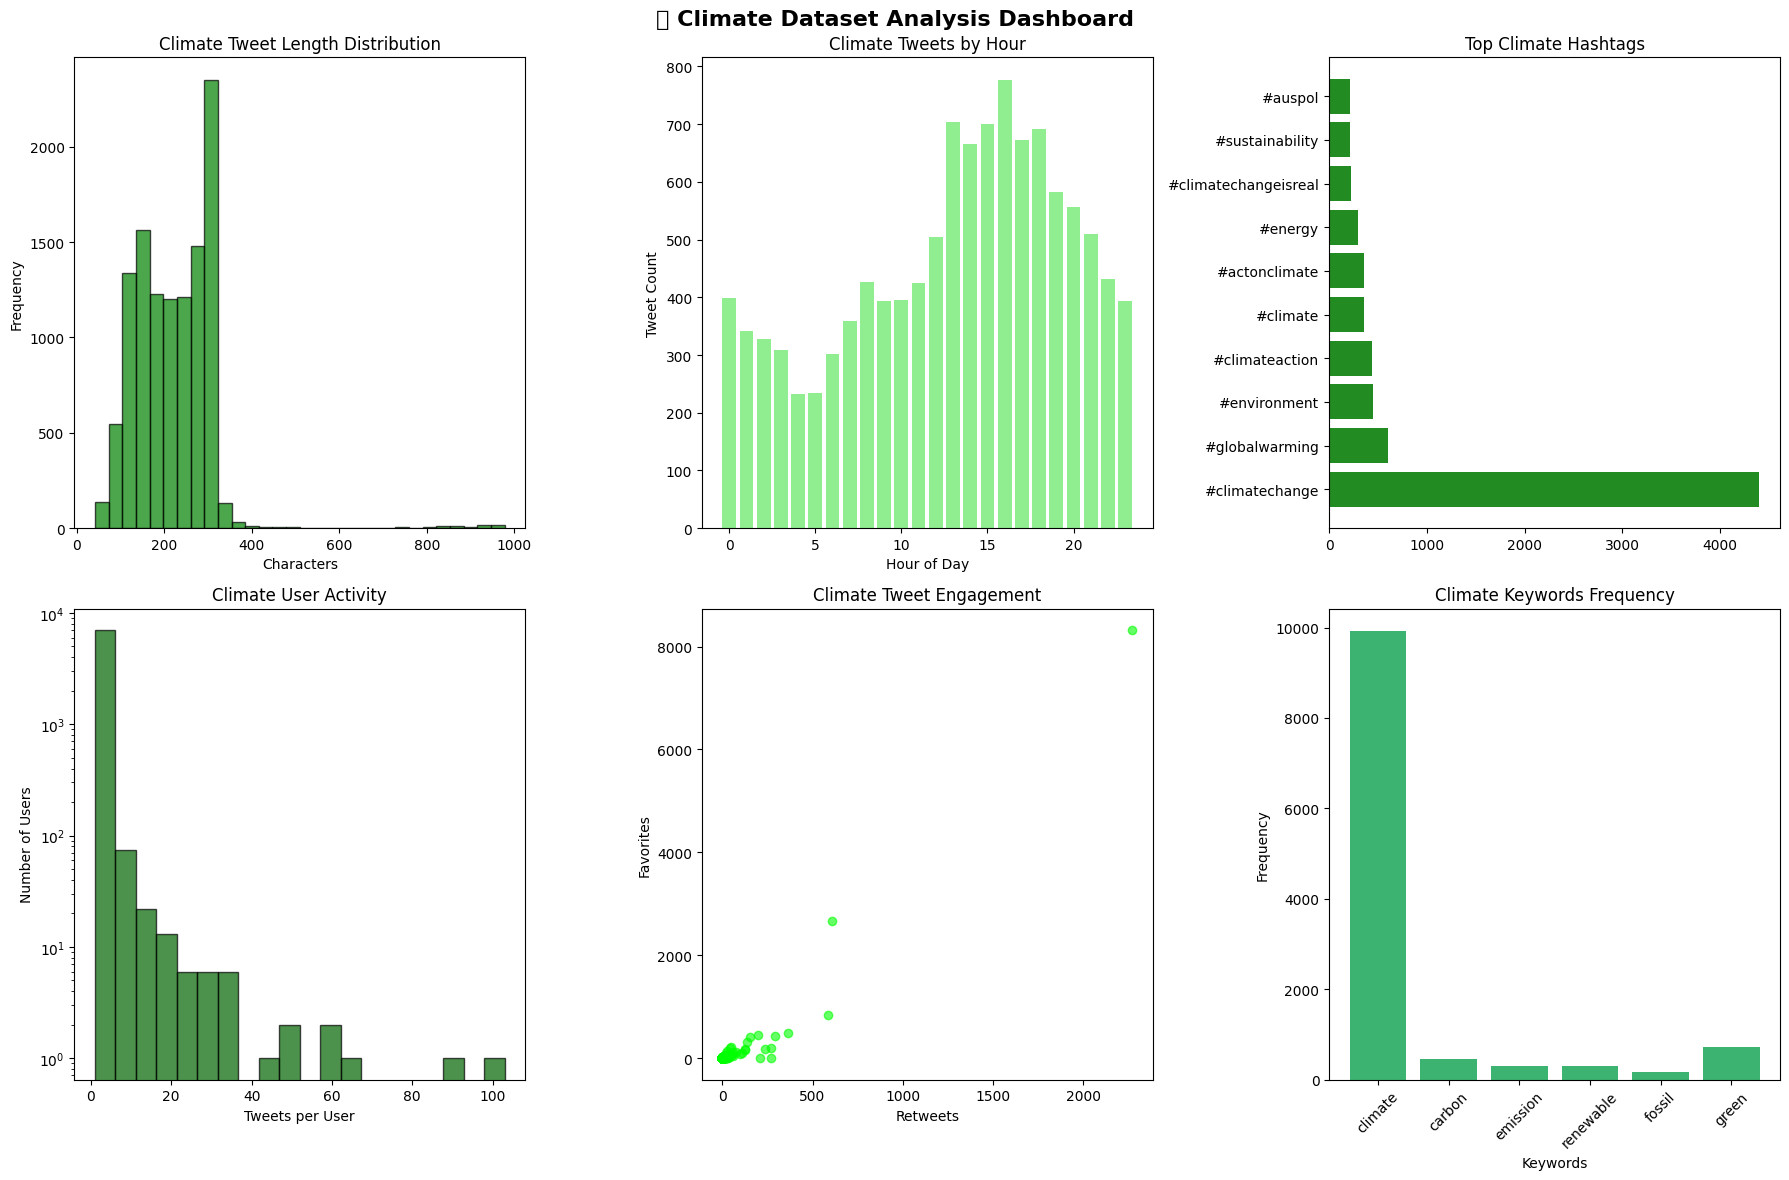


✅ Climate analysis complete!
💾 Current memory usage: 731.1 MB


In [6]:
# Run comprehensive climate analysis
print("🌍 RUNNING COMPREHENSIVE CLIMATE ANALYSIS")
print("=" * 80)

# Basic statistics
climate_stats = climate_analyzer.basic_statistics()

# Active users analysis
climate_active_data = climate_analyzer.analyze_active_users(min_tweets=6, max_users=1000)

# Generate visualizations
climate_viz = climate_analyzer.generate_climate_visualizations(climate_active_data)

print("\n✅ Climate analysis complete!")
print_memory_status()

In [7]:
# Export climate training data
def export_climate_training_data():
    """Export climate-specific training data for LLM agents"""
    print("📦 EXPORTING CLIMATE TRAINING DATA")
    print("=" * 50)
    
    # Export active user profiles
    active_users = climate_active_data['active_users']
    climate_focused = climate_active_data['climate_focused_users']
    
    user_profiles = []
    for user, tweet_count in active_users.items():
        profile = {
            'username': user,
            'tweet_count': tweet_count,
            'dataset': 'climate',
            'climate_focused': user in climate_focused
        }
        user_profiles.append(profile)
    
    profiles_df = pd.DataFrame(user_profiles)
    profiles_df.to_csv('climate_user_profiles.csv', index=False)
    print(f"✅ Exported {len(user_profiles)} user profiles")
    
    # Export sample tweets
    active_tweets = climate_active_data['active_tweets']
    sample_tweets = active_tweets.sample(min(10000, len(active_tweets)), random_state=42)
    
    tweet_data = []
    for _, tweet in sample_tweets.iterrows():
        tweet_record = {
            'text': tweet.get('full_text', ''),
            'username': tweet.get('user.screen_name', ''),
            'timestamp': tweet.get('created_at', ''),
            'retweet_count': tweet.get('retweet_count', 0),
            'favorite_count': tweet.get('favorite_count', 0),
            'dataset': 'climate'
        }
        tweet_data.append(tweet_record)
    
    tweets_df = pd.DataFrame(tweet_data)
    tweets_df.to_csv('climate_training_tweets.csv', index=False)
    print(f"✅ Exported {len(tweet_data)} training tweets")
    
    # Export network data
    mention_network = climate_active_data['mention_network']
    network_data = []
    
    for user, mentions in mention_network.items():
        for mentioned_user in mentions:
            network_data.append({
                'source_user': user,
                'target_user': mentioned_user,
                'interaction_type': 'mention',
                'dataset': 'climate'
            })
    
    if network_data:
        network_df = pd.DataFrame(network_data)
        network_df.to_csv('climate_user_network.csv', index=False)
        print(f"✅ Exported {len(network_data)} network connections")
    
    print("\n🎯 Climate training data export complete!")
    return ['climate_user_profiles.csv', 'climate_training_tweets.csv', 'climate_user_network.csv']

# Export the data
climate_files = export_climate_training_data()
print(f"📁 Generated files: {climate_files}")

📦 EXPORTING CLIMATE TRAINING DATA
✅ Exported 184 user profiles
✅ Exported 2498 training tweets
✅ Exported 36 network connections

🎯 Climate training data export complete!
📁 Generated files: ['climate_user_profiles.csv', 'climate_training_tweets.csv', 'climate_user_network.csv']
✅ Exported 2498 training tweets
✅ Exported 36 network connections

🎯 Climate training data export complete!
📁 Generated files: ['climate_user_profiles.csv', 'climate_training_tweets.csv', 'climate_user_network.csv']


In [11]:
# Generate Markdown Summary Report
import os
from datetime import datetime

def generate_climate_markdown_summary():
    """Generate a markdown summary of the climate analysis results."""
    
    # Check if analysis was completed
    analysis_complete = 'climate_stats' in globals() and 'climate_active_data' in globals()
    
    summary_content = []
    summary_content.append("# Climate Twitter Dataset Analysis Summary")
    summary_content.append(f"\n**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    summary_content.append(f"**Dataset:** climate_tweets2.jsonl\n")
    
    if not analysis_complete:
        summary_content.append("⚠️ **Warning:** Analysis appears incomplete. Some statistics may be missing.\n")
    
    # Basic Statistics
    summary_content.append("## Dataset Overview")
    if 'climate_stats' in globals() and climate_stats:
        stats = climate_stats
        summary_content.append(f"- **Total tweets processed:** {stats.get('total_tweets', 'N/A'):,}" if isinstance(stats.get('total_tweets'), int) else f"- **Total tweets processed:** {stats.get('total_tweets', 'N/A')}")
        summary_content.append(f"- **Unique users:** {stats.get('unique_users', 'N/A'):,}" if isinstance(stats.get('unique_users'), int) else f"- **Unique users:** {stats.get('unique_users', 'N/A')}")
        summary_content.append(f"- **Users with 6+ tweets:** {stats.get('active_users_6plus', 'N/A'):,}" if isinstance(stats.get('active_users_6plus'), int) else f"- **Users with 6+ tweets:** {stats.get('active_users_6plus', 'N/A')}")
        
        if stats.get('avg_tweets_per_user'):
            summary_content.append(f"- **Average tweets per user:** {stats.get('avg_tweets_per_user', 0):.2f}")
        
        if stats.get('date_range'):
            date_range = stats['date_range']
            summary_content.append(f"- **Date range:** {date_range.get('start', 'N/A')} to {date_range.get('end', 'N/A')}")
    else:
        summary_content.append("- Basic statistics not available")
    
    # Active Users Analysis
    summary_content.append("\n## Active Users Analysis (6+ tweets)")
    if 'climate_active_data' in globals() and climate_active_data:
        active_data = climate_active_data
        
        # Get active users data properly  
        if 'active_users' in active_data and len(active_data['active_users']) > 0:
            active_users = active_data['active_users']
            summary_content.append(f"- **Total active users:** {len(active_users)}")
            
            # Get tweet counts from the active_users Series
            tweet_counts = active_users.values
            summary_content.append(f"- **Average tweets per active user:** {tweet_counts.mean():.2f}")
            summary_content.append(f"- **Max tweets by single user:** {tweet_counts.max()}")
            summary_content.append(f"- **Min tweets by active user:** {tweet_counts.min()}")
            
            # Additional insights from active_tweets if available
            if 'active_tweets' in active_data: 
                active_tweets = active_data['active_tweets']
                summary_content.append(f"- **Total tweets from active users:** {len(active_tweets)}")
                
                # Engagement statistics
                if 'retweet_count' in active_tweets.columns:
                    summary_content.append(f"- **Average retweets per tweet:** {active_tweets['retweet_count'].mean():.2f}")
                if 'favorite_count' in active_tweets.columns:
                    summary_content.append(f"- **Average favorites per tweet:** {active_tweets['favorite_count'].mean():.2f}")
        else:
            summary_content.append("- **Total active users:** N/A")
        
        # Behavioral patterns
        summary_content.append(f"\n### Behavioral Patterns")
        mention_network = active_data.get('mention_network', {})
        if mention_network:
            summary_content.append(f"- **Users with network connections:** {len(mention_network)}")
            total_connections = sum(len(connections) for connections in mention_network.values())
            summary_content.append(f"- **Total mention connections:** {total_connections}")
        
        # Climate-focused users
        climate_focused = active_data.get('climate_focused_users', [])
        if climate_focused:
            summary_content.append(f"- **Climate-focused users:** {len(climate_focused)}")
        
        # Content analysis
        summary_content.append(f"\n### Content Analysis")
        
        # Top hashtags and mentions from mention network
        if mention_network:
            summary_content.append(f"\n**Network Analysis:**")
            # Most connected users
            most_connected = sorted(mention_network.items(), key=lambda x: len(x[1]), reverse=True)[:5]
            if most_connected:
                summary_content.append(f"- **Most connected users:**")
                for user, connections in most_connected:
                    summary_content.append(f"  - {user}: {len(connections)} connections")
    else:
        summary_content.append("- Active user analysis not available")
    
    # Climate-specific insights
    summary_content.append("\n## Climate-Specific Insights")
    
    # Climate statistics from basic stats
    if 'climate_stats' in globals() and climate_stats:
        summary_content.append("**Climate content analysis:**")
        # Look for content statistics
        if 'total_tweets' in climate_stats:
            summary_content.append(f"- Total tweets analyzed: {climate_stats['total_tweets']}")
        if 'avg_tweet_length' in climate_stats:
            summary_content.append(f"- Average tweet length: {climate_stats['avg_tweet_length']:.1f} characters")
        if 'total_retweets' in climate_stats:
            summary_content.append(f"- Total retweets: {climate_stats['total_retweets']}")
        if 'total_favorites' in climate_stats:
            summary_content.append(f"- Total favorites: {climate_stats['total_favorites']}")
    
    # Climate-focused users insights
    if 'climate_active_data' in globals() and climate_active_data:
        climate_focused = climate_active_data.get('climate_focused_users', [])
        if climate_focused:
            total_active = len(climate_active_data.get('active_users', []))
            climate_ratio = len(climate_focused) / total_active * 100 if total_active > 0 else 0
            summary_content.append(f"\n**Climate Discussion Patterns:**")
            summary_content.append(f"- Climate-focused users: {len(climate_focused)} ({climate_ratio:.1f}% of active users)")
            summary_content.append(f"- These users have >30% climate-related content in their tweets")
    else:
        summary_content.append("- Climate keyword analysis not available")
    
    # Export information
    summary_content.append("\n## Data Export")
    export_files = []
    potential_files = [
        'climate_llm_training_data.json',
        'climate_active_users_export.json',
        'climate_training_data_export.json'
    ]
    
    for file in potential_files:
        if os.path.exists(file):
            export_files.append(file)
    
    if export_files:
        summary_content.append("**Generated files:**")
        for file in export_files:
            file_size = os.path.getsize(file) / (1024*1024)  # MB
            summary_content.append(f"- `{file}` ({file_size:.2f} MB)")
    else:
        summary_content.append("- No export files generated yet")
    
    # Technical notes
    summary_content.append("\n## Technical Notes")
    summary_content.append("- Analysis focused on users with 6+ tweets for LLM training data quality")
    summary_content.append("- Memory-efficient processing used for large dataset handling")
    summary_content.append("- Behavioral patterns include reply, retweet, mention, and hashtag usage")
    summary_content.append("- Export data structured for LLM agent fine-tuning workflows")
    
    # Footer
    summary_content.append("\n---")
    summary_content.append("*Generated by Climate Twitter Analysis Notebook*")
    
    return "\n".join(summary_content)

# Generate and save the summary
try:
    markdown_summary = generate_climate_markdown_summary()
    
    # Save to file
    summary_filename = "climate_analysis_summary.md"
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write(markdown_summary)
    
    print(f"✅ Climate analysis summary saved to: {summary_filename}")
    print(f"📊 Summary length: {len(markdown_summary)} characters")
    
    # Show preview of first few lines
    lines = markdown_summary.split('\n')
    print(f"\n📋 Preview (first 10 lines):")
    for i, line in enumerate(lines[:10]):
        print(f"   {line}")
    if len(lines) > 10:
        print(f"   ... and {len(lines)-10} more lines")
        
except Exception as e:
    print(f"❌ Error generating climate summary: {e}")
    print("This might be due to incomplete analysis. Please ensure all analysis cells have been run.")

✅ Climate analysis summary saved to: climate_analysis_summary.md
📊 Summary length: 1620 characters

📋 Preview (first 10 lines):
   # Climate Twitter Dataset Analysis Summary
   
   **Generated:** 2025-07-02 13:35:24
   **Dataset:** climate_tweets2.jsonl
   
   ## Dataset Overview
   - **Total tweets processed:** 11,333
   - **Unique users:** 7,142
   - **Users with 6+ tweets:** N/A
   
   ... and 46 more lines
